# Packages used

In [1]:
!conda list
!which python
!python --version
!jupyter kernelspec list

# packages in environment at /Users/douglas/anaconda3/envs/jupyter_venv:
#
# Name                    Version                   Build  Channel
adjusttext                1.2.0              pyhd8ed1ab_0    conda-forge
anyio                     4.2.0           py312hecd8cb5_0  
appnope                   0.1.3           py312hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py312h6c40b1e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
async-lru                 2.0.4           py312hecd8cb5_0  
attrs                     23.1.0          py312hecd8cb5_0  
babel                     2.11.0          py312hecd8cb5_0  
beautifulsoup4            4.12.3          py312hecd8cb5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
bottleneck                1.3.7           py312h32608ca_0  
brotli                    1.0.9                h6c40b1e_8  
br

# Data
Input: NutriTech_otherdata_AVG.xlsx, flx_df files for each group (e.g., flx_df_W5D2T0_.csv)

# Function for clustering groups then kruskal wallis, with verifying code included

In [16]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_pca_kmeans_vs_median(file_ID, n_components_pca, clusters_to_use, pc_x, pc_y, variable_to_compare, method='kmeans'):
    # Load the data
    csv_file = f'{file_ID}.csv'  # File name of the dataset
    pw_flx1 = pd.read_csv(csv_file)
    file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
    xls = pd.ExcelFile(file_path)
    df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

    # Extract the participant IDs from NutriTech data
    nutritech_ids = df_week5_before['name'].tolist()
    pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

    # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
    mapping = {}
    for nt_id in nutritech_ids:
        if nt_id in pw_flx1_ids.values:
            matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
            mapping[nt_id] = matched_column

    # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
    pca_labels = []
    nutritech_labels = []
    for column in pw_flx1.columns:
        matched_id = next((key for key, value in mapping.items() if value == column), None)
        if matched_id:
            label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
            pca_labels.append(label)
            nutritech_labels.append(matched_id)
        else:
            pca_labels.append(np.nan)  # Handle missing data
            nutritech_labels.append('Unknown')

    pca_labels = np.array(pca_labels)
    finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
    norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
    cmap = plt.cm.viridis
    colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

    # Step 2: Perform PCA
    pca = PCA(n_components=n_components_pca)
    pcaData = pca.fit_transform(pw_flx1.T)
    print(pca.explained_variance_ratio_)

    # Choose the method: 'kmeans' or 'median_split'
    if method == 'kmeans':
        # Step 3a: Perform K-Means Clustering
        kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

        # Step 4a: Visualize PCA with K-Means Clusters and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for i in range(clusters_to_use):
            cluster_indices = clusters == i
            plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i+1}', alpha=0.7)
            for j in np.where(cluster_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'K-Means Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5a: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_clusters = []
        for i in range(clusters_to_use):
            cluster_values = pca_labels[clusters == i]
            cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
            if len(cluster_values) > 0:
                valid_clusters.append(cluster_values)

        if len(valid_clusters) > 1:
            kruskal_results = kruskal(*valid_clusters)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (K-Means): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid clusters for Kruskal-Wallis test for {variable_to_compare} (K-Means).")

    elif method == 'median_split':
        # Step 3b: Group by Median Split
        median_value = np.nanmedian(pca_labels)  # Calculate the median of the variable
        group_labels = np.array(['Bottom Half' if val <= median_value else 'Top Half' for val in pca_labels])

        # Step 4b: Visualize PCA with Median Split Groups and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for group in ['Bottom Half', 'Top Half']:
            group_indices = group_labels == group
            plt.scatter(pcaData[group_indices, pc_x], pcaData[group_indices, pc_y], label=group, alpha=0.7)
            for j in np.where(group_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'Median Split on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5b: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_groups = []
        for group in ['Bottom Half', 'Top Half']:
            group_values = pca_labels[group_labels == group]
            group_values = group_values[~np.isnan(group_values)]  # Remove NaN values
            if len(group_values) > 0:
                valid_groups.append(group_values)

        if len(valid_groups) > 1:
            kruskal_results = kruskal(*valid_groups)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (Median Split): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid groups for Kruskal-Wallis test for {variable_to_compare} (Median Split).")

    else:
        print("Invalid method. Choose 'kmeans' or 'median_split'.")

    # Step 6: Print Group/Cluster Assignments for Verification
    if method == 'kmeans':
        assignment_data = pd.DataFrame({
            'NutriTech ID': nutritech_labels,
            'Cluster': clusters,
            f'{variable_to_compare}': pca_labels
        })
    elif method == 'median_split':
        assignment_data = pd.DataFrame({
            'NutriTech ID': nutritech_labels,
            'Group': group_labels,
            f'{variable_to_compare}': pca_labels
        })

    print(f"\nAssignments and {variable_to_compare} Values:")
    print(assignment_data.sort_values(by='Cluster' if method == 'kmeans' else 'Group'))




# Function for clustering groups then kruskal wallis, with verifying code excluded

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def analyze_pca_kmeans_vs_median(file_ID, n_components_pca, clusters_to_use, pc_x, pc_y, variable_to_compare, method='kmeans'):
    # Load the data
    csv_file = f'{file_ID}.csv'  # File name of the dataset
    pw_flx1 = pd.read_csv(csv_file)
    file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 13/NutriTech_otherdata_AVG.xlsx'
    xls = pd.ExcelFile(file_path)
    df_week5_before = pd.read_excel(xls, sheet_name='week5_before_intervention', header=1)

    # Extract the participant IDs from NutriTech data
    nutritech_ids = df_week5_before['name'].tolist()
    pw_flx1_ids = pw_flx1.columns.str.extract(r'(NT\d+)_')[0]

    # Map the NutriTech IDs to the corresponding columns in pw_flx1.csv
    mapping = {}
    for nt_id in nutritech_ids:
        if nt_id in pw_flx1_ids.values:
            matched_column = pw_flx1.columns[pw_flx1_ids[pw_flx1_ids == nt_id].index[0]]
            mapping[nt_id] = matched_column

    # Extract corresponding labels (numeric values) for the columns in pw_flx1.csv based on the mapping
    pca_labels = []
    nutritech_labels = []
    for column in pw_flx1.columns:
        matched_id = next((key for key, value in mapping.items() if value == column), None)
        if matched_id:
            label = df_week5_before.loc[df_week5_before['name'] == matched_id, variable_to_compare].values[0]
            pca_labels.append(label)
            nutritech_labels.append(matched_id)
        else:
            pca_labels.append(np.nan)  # Handle missing data
            nutritech_labels.append('Unknown')

    pca_labels = np.array(pca_labels)
    finite_labels = pca_labels[np.isfinite(pca_labels) & (pca_labels > 0)]
    norm = LogNorm(vmin=finite_labels.min(), vmax=finite_labels.max())
    cmap = plt.cm.viridis
    colors = np.array([cmap(norm(val)) if np.isfinite(val) and val > 0 else (0.5, 0.5, 0.5, 1.0) for val in pca_labels])

    # Step 2: Perform PCA
    pca = PCA(n_components=n_components_pca)
    pcaData = pca.fit_transform(pw_flx1.T)
    print(pca.explained_variance_ratio_)

    # Choose the method: 'kmeans' or 'median_split'
    if method == 'kmeans':
        # Step 3a: Perform K-Means Clustering
        kmeans = KMeans(n_clusters=clusters_to_use, random_state=0)
        clusters = kmeans.fit_predict(pcaData[:, [pc_x, pc_y]])

        # Step 4a: Visualize PCA with K-Means Clusters and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for i in range(clusters_to_use):
            cluster_indices = clusters == i
            plt.scatter(pcaData[cluster_indices, pc_x], pcaData[cluster_indices, pc_y], label=f'Cluster {i+1}', alpha=0.7)
            for j in np.where(cluster_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'K-Means Clustering on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5a: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_clusters = []
        for i in range(clusters_to_use):
            cluster_values = pca_labels[clusters == i]
            cluster_values = cluster_values[~np.isnan(cluster_values) & (cluster_values > 0)]  # Remove NaN and zero values
            if len(cluster_values) > 0:
                valid_clusters.append(cluster_values)

        if len(valid_clusters) > 1:
            kruskal_results = kruskal(*valid_clusters)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (K-Means): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid clusters for Kruskal-Wallis test for {variable_to_compare} (K-Means).")

    elif method == 'median_split':
        # Step 3b: Group by Median Split
        median_value = np.nanmedian(pca_labels)  # Calculate the median of the variable
        group_labels = np.array(['Bottom Half' if val <= median_value else 'Top Half' for val in pca_labels])

        # Step 4b: Visualize PCA with Median Split Groups and NutriTech IDs
        plt.figure(figsize=(10, 8))
        for group in ['Bottom Half', 'Top Half']:
            group_indices = group_labels == group
            plt.scatter(pcaData[group_indices, pc_x], pcaData[group_indices, pc_y], label=group, alpha=0.7)
            for j in np.where(group_indices)[0]:
                plt.text(pcaData[j, pc_x], pcaData[j, pc_y], nutritech_labels[j], fontsize=8, ha='right')

        plt.xlabel(f'PC{pc_x+1}')
        plt.ylabel(f'PC{pc_y+1}')
        plt.title(f'Median Split on {variable_to_compare} (PC{pc_x+1} vs PC{pc_y+1})')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Step 5b: Perform Kruskal-Wallis Test, ignoring NaN values
        valid_groups = []
        for group in ['Bottom Half', 'Top Half']:
            group_values = pca_labels[group_labels == group]
            group_values = group_values[~np.isnan(group_values)]  # Remove NaN values
            if len(group_values) > 0:
                valid_groups.append(group_values)

        if len(valid_groups) > 1:
            kruskal_results = kruskal(*valid_groups)
            print(f"Kruskal-Wallis test result for {variable_to_compare} (Median Split): H-statistic = {kruskal_results.statistic}, p-value = {kruskal_results.pvalue}")
        else:
            print(f"Not enough valid groups for Kruskal-Wallis test for {variable_to_compare} (Median Split).")

    else:
        print("Invalid method. Choose 'kmeans' or 'median_split'.")

    




# W5D2T0 Clustering + kruskall wallis

[0.37824503 0.32473143 0.13652004 0.03247876]


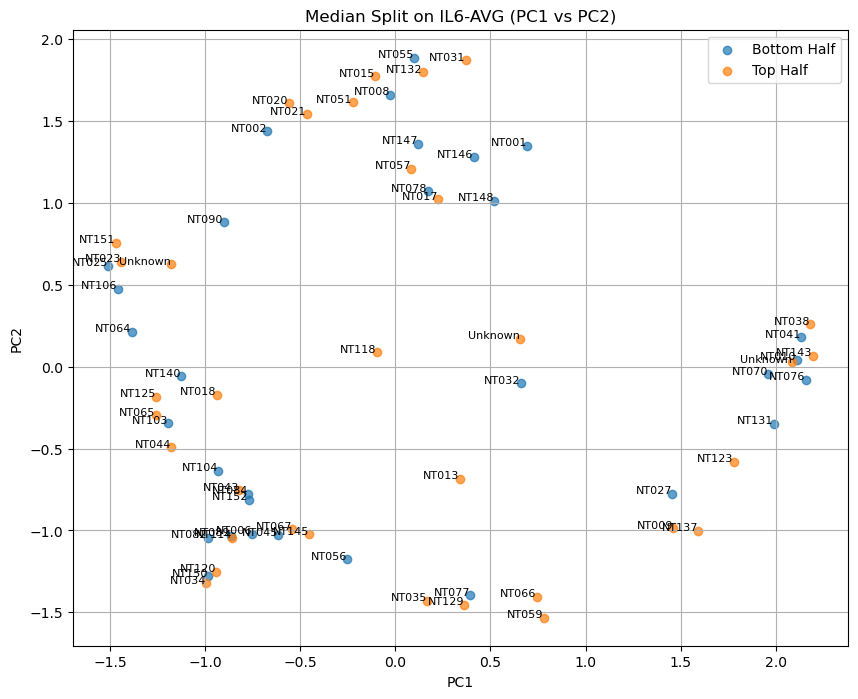

Kruskal-Wallis test result for IL6-AVG (Median Split): H-statistic = 46.18524919307698, p-value = 1.0758391749700376e-11


In [14]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D2T0_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='IL6-AVG',
    method='median_split'  # Can be 'kmeans', 'median_split', or both
)

[0.37824503 0.32473143 0.13652004 0.03247876]


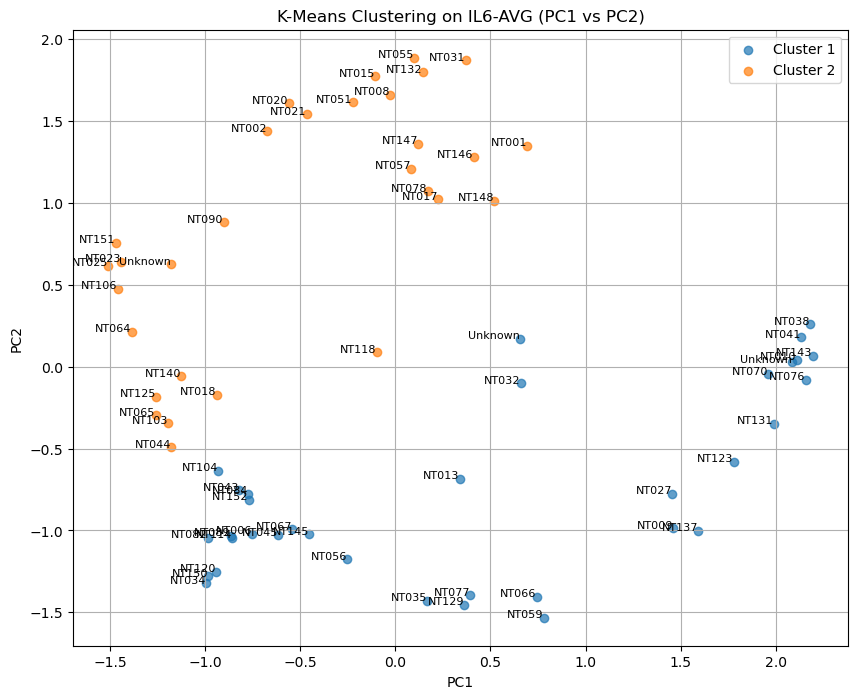

Kruskal-Wallis test result for IL6-AVG (K-Means): H-statistic = 0.013477883014917074, p-value = 0.9075778180799516

Assignments and IL6-AVG Values:
   NutriTech ID  Cluster   IL6-AVG
32        NT009        0  0.560888
1         NT131        0  0.293274
63        NT114        0  0.661465
3         NT070        0  0.341700
4         NT082        0  0.021000
..          ...      ...       ...
60        NT044        1  2.361341
61        NT055        1  0.021000
62      Unknown        1       NaN
2         NT025        1  0.021000
0         NT106        1  0.294271

[65 rows x 3 columns]


In [18]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D2T0_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='IL6-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

# W5D2T120

[0.37824503 0.32473143 0.13652004 0.03247876]


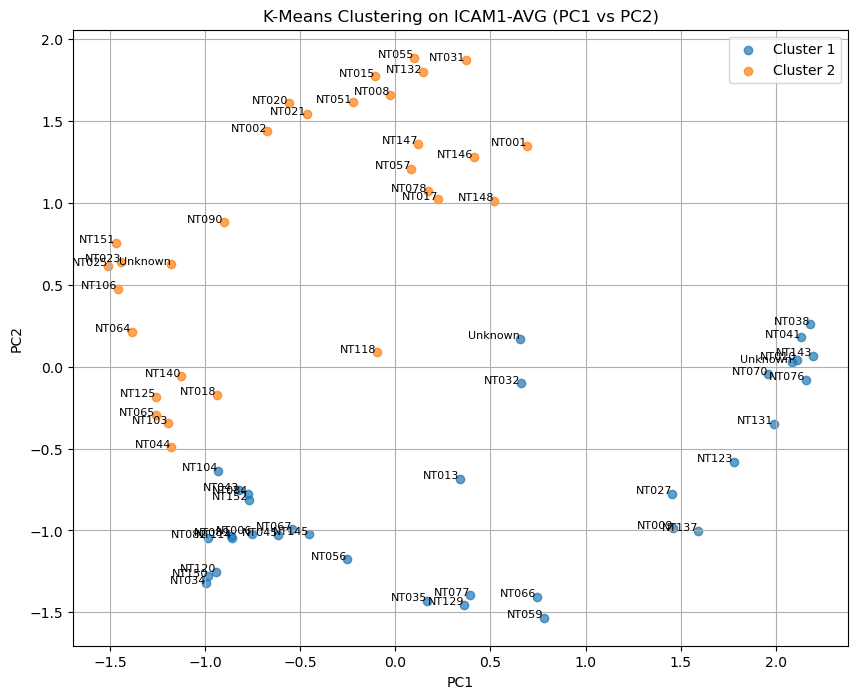

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 0.030033370411558735, p-value = 0.8624145342562937

Assignments and ICAM1-AVG Values:
   NutriTech ID  Cluster   ICAM1-AVG
32        NT009        0  259.348381
1         NT131        0  230.381053
63        NT114        0  198.776877
3         NT070        0  196.402812
4         NT082        0  266.932907
..          ...      ...         ...
60        NT044        1  255.313924
61        NT055        1  156.123253
62      Unknown        1         NaN
2         NT025        1  247.589013
0         NT106        1  334.707407

[65 rows x 3 columns]


In [29]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D2T0_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='ICAM1-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

[0.54239113 0.16269086 0.09566434 0.04797832]


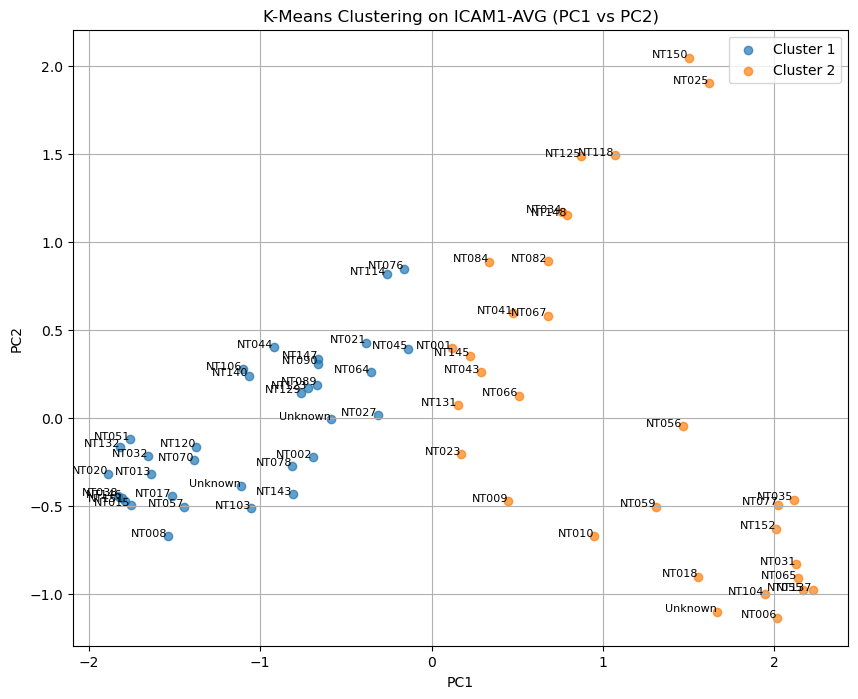

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 2.9534899888765267, p-value = 0.08569231944637089

Assignments and ICAM1-AVG Values:
   NutriTech ID  Cluster   ICAM1-AVG
0         NT038        0  244.562522
64        NT129        0  246.755764
2         NT078        0  429.050657
60        NT090        0  362.448199
4         NT008        0  181.376020
..          ...      ...         ...
3         NT009        1  259.348381
61        NT118        1  257.455979
62        NT082        1  266.932907
63        NT059        1  221.133892
1         NT148        1  241.577620

[65 rows x 3 columns]


In [28]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D2T120_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='ICAM1-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

[0.378123   0.19748016 0.09114667 0.082432  ]


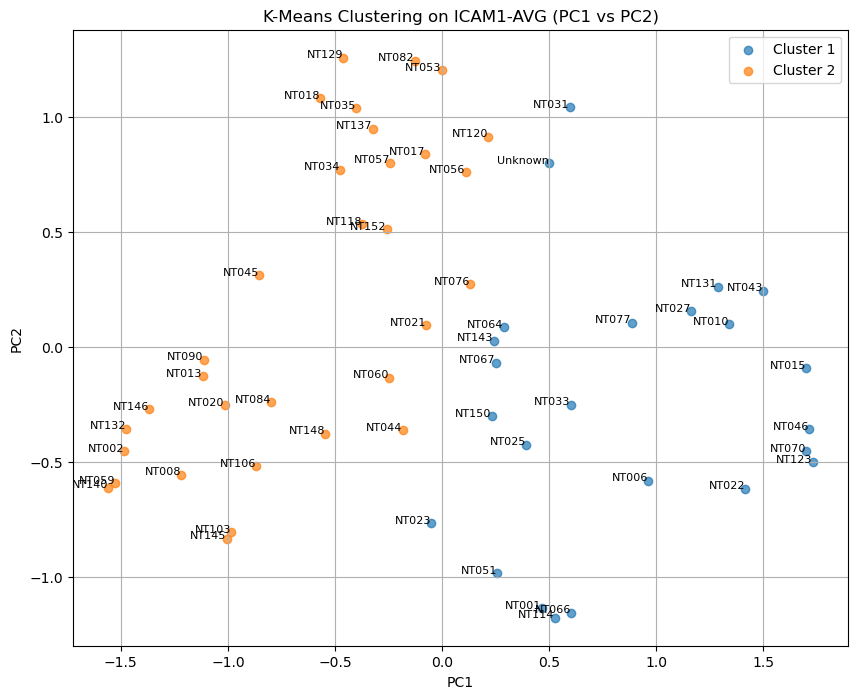

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 5.372306515364045, p-value = 0.020458906728038496

Assignments and ICAM1-AVG Values:
   NutriTech ID  Cluster   ICAM1-AVG
3         NT150        0  253.487275
4         NT027        0  190.205499
5         NT067        0  118.807174
11      Unknown        0         NaN
13        NT043        0  226.831434
14        NT143        0  256.151366
10        NT051        0  215.183143
16        NT033        0  199.514632
27        NT064        0  124.296881
21        NT010        0  167.191012
30        NT114        0  198.776877
28        NT031        0  192.156277
17        NT066        0  207.157354
37        NT070        0  196.402812
35        NT015        0  260.817345
32        NT023        0  187.847345
40        NT077        0  220.518120
42        NT006        0  229.231839
45        NT001        0  257.048346
39        NT022        0  248.877064
36        NT025        0  247.589013
48        NT131        0  230.38105

In [32]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T120_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='ICAM1-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

[0.37824503 0.32473143 0.13652004 0.03247876]


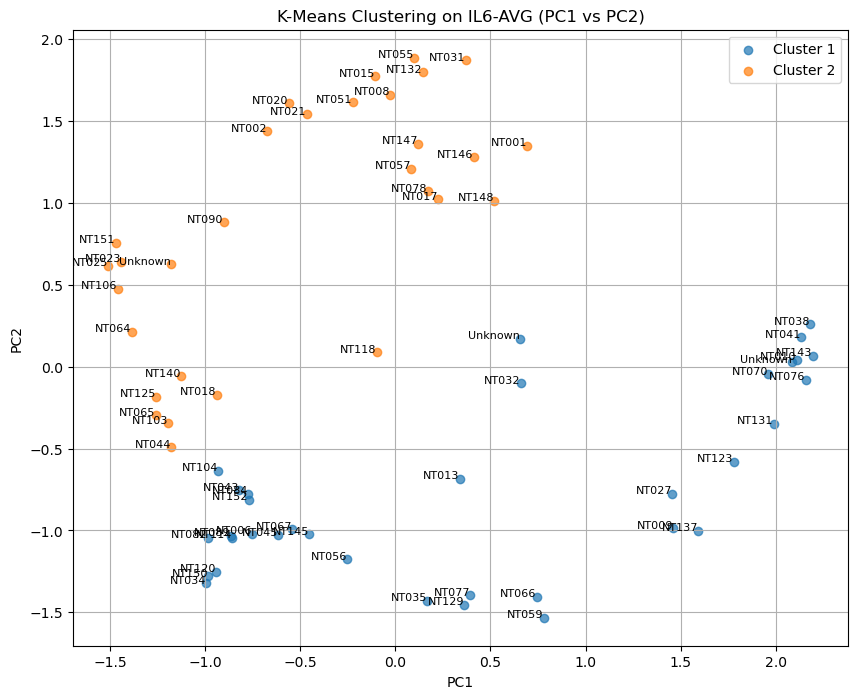

Kruskal-Wallis test result for IL6-AVG (K-Means): H-statistic = 0.013477883014917074, p-value = 0.9075778180799516

Assignments and IL6-AVG Values:
   NutriTech ID  Cluster   IL6-AVG
32        NT009        0  0.560888
1         NT131        0  0.293274
63        NT114        0  0.661465
3         NT070        0  0.341700
4         NT082        0  0.021000
..          ...      ...       ...
60        NT044        1  2.361341
61        NT055        1  0.021000
62      Unknown        1       NaN
2         NT025        1  0.021000
0         NT106        1  0.294271

[65 rows x 3 columns]


In [20]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D2T0_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='IL6-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

[0.54239113 0.16269086 0.09566434 0.04797832]


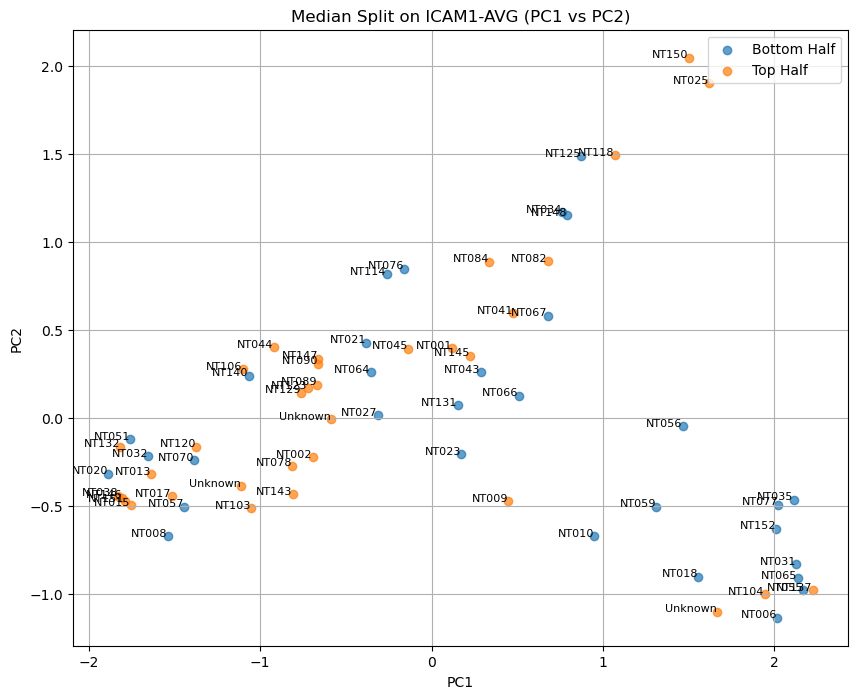

Kruskal-Wallis test result for ICAM1-AVG (Median Split): H-statistic = 45.76190476190476, p-value = 1.3353534438911957e-11

Assignments and ICAM1-AVG Values:
   NutriTech ID        Group   ICAM1-AVG
20        NT056  Bottom Half  221.055772
21        NT043  Bottom Half  226.831434
51        NT064  Bottom Half  124.296881
50        NT114  Bottom Half  198.776877
25        NT027  Bottom Half  190.205499
..          ...          ...         ...
33        NT001     Top Half  257.048346
35        NT013     Top Half  296.313170
37        NT041     Top Half  261.812745
42        NT147     Top Half  365.318865
64        NT129     Top Half  246.755764

[65 rows x 3 columns]


In [24]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D2T120_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='ICAM1-AVG',
    method='median_split'  # Can be 'kmeans', 'median_split', or both
)

[0.54239113 0.16269086 0.09566434 0.04797832]


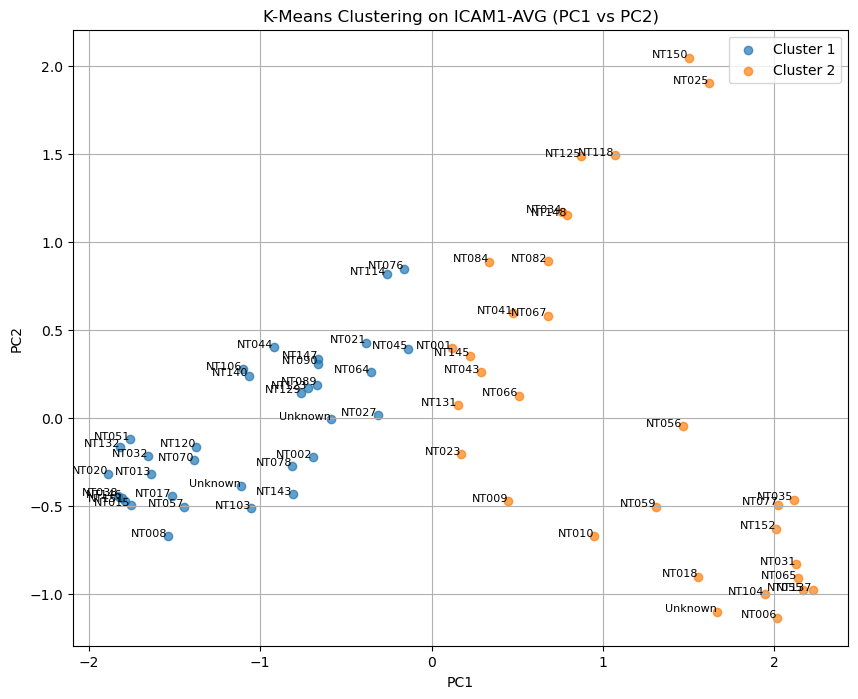

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 2.9534899888765267, p-value = 0.08569231944637089

Assignments and ICAM1-AVG Values:
   NutriTech ID  Cluster   ICAM1-AVG
0         NT038        0  244.562522
64        NT129        0  246.755764
2         NT078        0  429.050657
60        NT090        0  362.448199
4         NT008        0  181.376020
..          ...      ...         ...
3         NT009        1  259.348381
61        NT118        1  257.455979
62        NT082        1  266.932907
63        NT059        1  221.133892
1         NT148        1  241.577620

[65 rows x 3 columns]


In [25]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D2T120_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='ICAM1-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

# W5D3T0

[0.378123   0.19748016 0.09114667 0.082432  ]


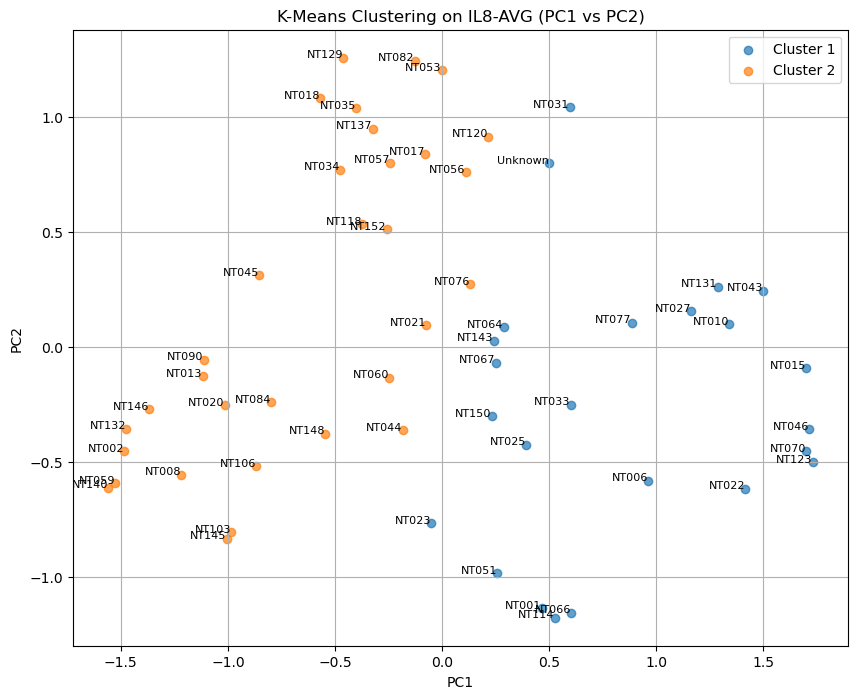

Kruskal-Wallis test result for IL8-AVG (K-Means): H-statistic = 2.5619533341833574, p-value = 0.1094632593991044

Assignments and IL8-AVG Values:
   NutriTech ID  Cluster   IL8-AVG
3         NT150        0  4.226411
4         NT027        0  1.240173
5         NT067        0  1.931681
11      Unknown        0       NaN
13        NT043        0  1.353812
14        NT143        0  1.800043
10        NT051        0  2.232902
16        NT033        0  1.291073
27        NT064        0  0.943165
21        NT010        0  0.909672
30        NT114        0  1.124954
28        NT031        0  2.553543
17        NT066        0  2.069216
37        NT070        0  1.366415
35        NT015        0  1.754245
32        NT023        0  2.159418
40        NT077        0  1.218936
42        NT006        0  1.200873
45        NT001        0  1.199212
39        NT022        0  2.205576
36        NT025        0  1.714444
48        NT131        0  1.418531
44        NT123        0  1.452929
47        NT04

In [40]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T120_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0,
    pc_y=1,
    variable_to_compare='IL8-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

[0.36762544 0.25403733 0.08680735 0.06651043]


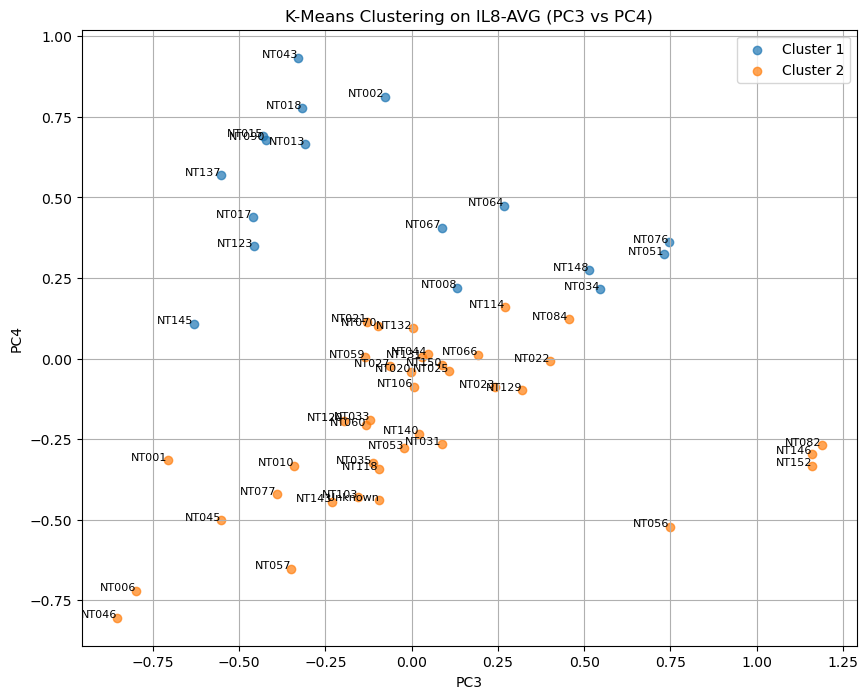

Kruskal-Wallis test result for IL8-AVG (K-Means): H-statistic = 0.3892759069229612, p-value = 0.5326802615030994

Assignments and IL8-AVG Values:
   NutriTech ID  Cluster   IL8-AVG
13        NT145        0  1.244048
14        NT051        0  2.232902
10        NT015        0  1.754245
8         NT148        0  1.908087
26        NT017        0  1.248674
30        NT064        0  0.943165
18        NT034        0  1.867816
16        NT018        0  1.297207
49        NT002        0  1.664656
44        NT043        0  1.353812
40        NT090        0  1.412874
39        NT123        0  1.452929
36        NT067        0  1.931681
35        NT137        0  1.403412
33        NT076        0  1.612073
32        NT008        0  2.781790
55        NT013        0  2.227291
15        NT066        1  2.069216
9         NT077        1  1.218936
12        NT033        1  1.291073
20        NT056        1  2.369146
21        NT070        1  1.366415
17        NT082        1  1.603067
11        NT02

In [21]:
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T0_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=2,
    pc_y=3,
    variable_to_compare='IL8-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

[0.36762544 0.25403733 0.08680735 0.06651043]


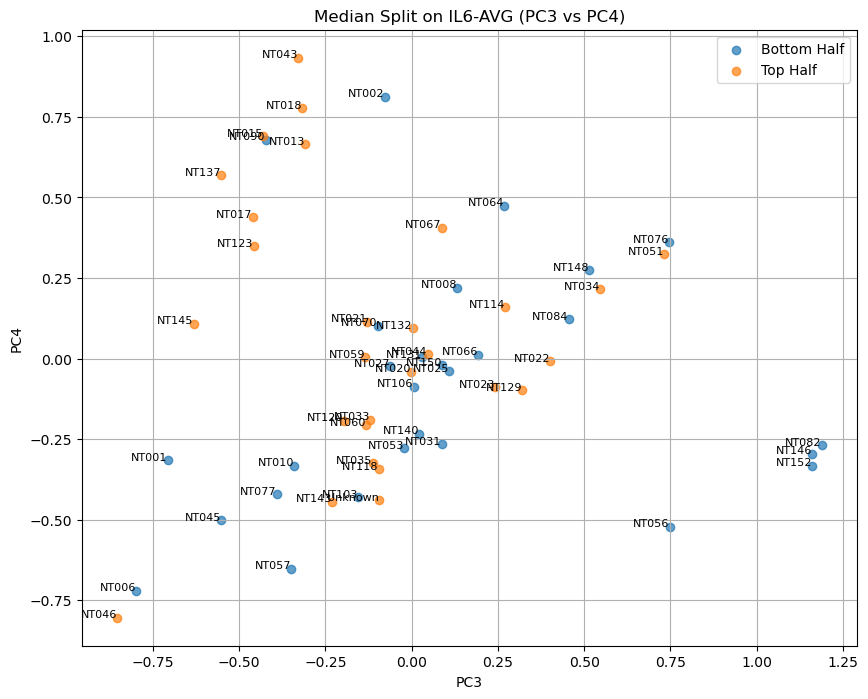

Kruskal-Wallis test result for IL6-AVG (Median Split): H-statistic = 40.74251497005988, p-value = 1.736673718935009e-10


In [11]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T0_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=2,
    pc_y=3,
    variable_to_compare='IL6-AVG',
    method='median_split'  # Can be 'kmeans', 'median_split', or both
)

# W5D3T120, code from docs, FBA = true

[0.378123   0.19748016 0.09114667 0.082432  ]


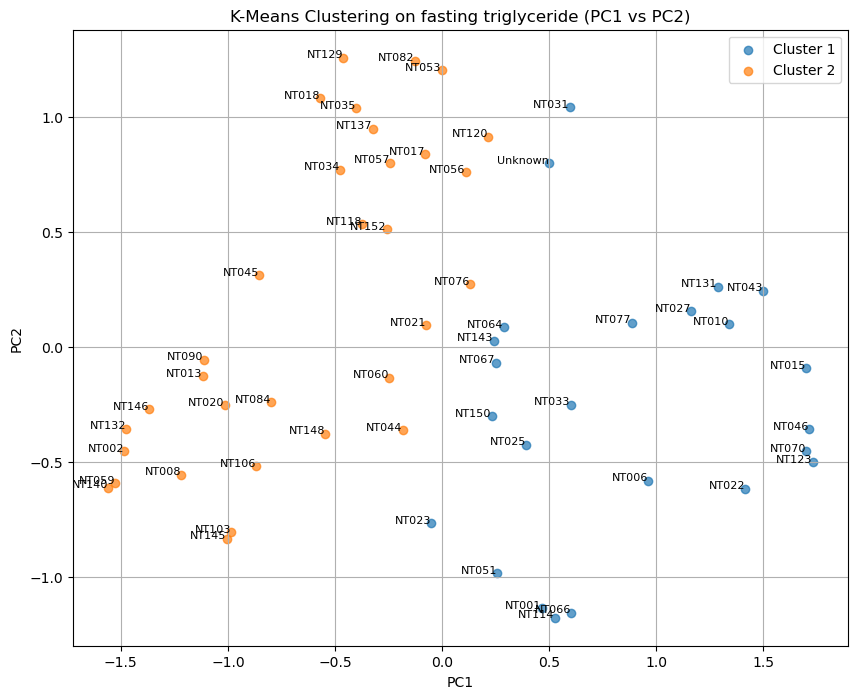

Kruskal-Wallis test result for fasting triglyceride (K-Means): H-statistic = 1.048325737906795, p-value = 0.3058929997678078

Assignments and fasting triglyceride Values:
   NutriTech ID  Cluster  fasting triglyceride
3         NT150        0              1.010000
4         NT027        0              1.400000
5         NT067        0              0.990000
11      Unknown        0                   NaN
13        NT043        0              1.920000
14        NT143        0              1.260000
10        NT051        0              0.980000
16        NT033        0              0.760000
27        NT064        0              2.400000
21        NT010        0              0.680000
30        NT114        0              0.710000
28        NT031        0              1.190000
17        NT066        0              2.290000
37        NT070        0              0.960000
35        NT015        0              0.750000
32        NT023        0              0.840000
40        NT077        0      

In [33]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T120_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='fasting triglyceride',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

[0.378123   0.19748016 0.09114667 0.082432  ]


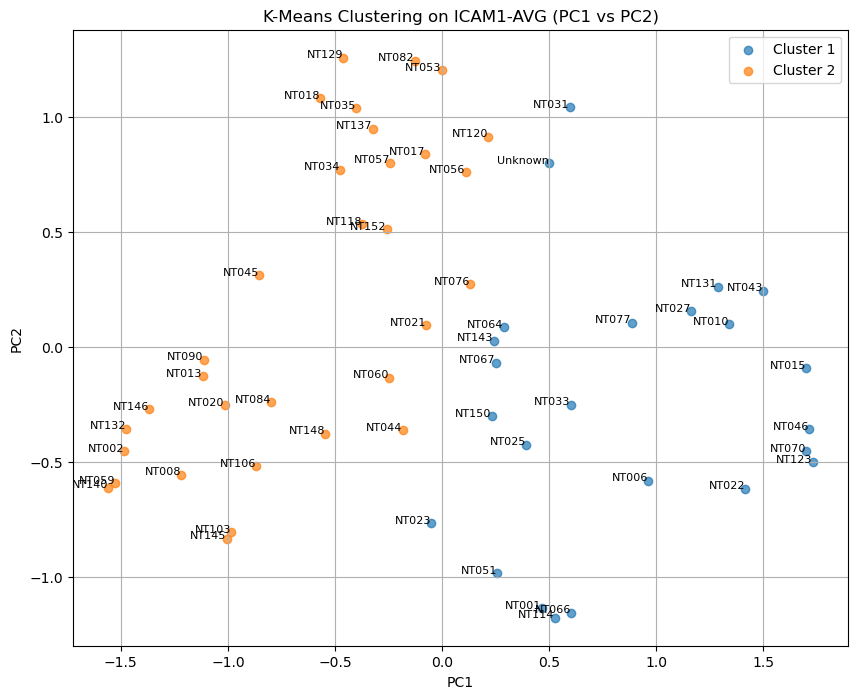

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 5.372306515364045, p-value = 0.020458906728038496

Assignments and ICAM1-AVG Values:
   NutriTech ID  Cluster   ICAM1-AVG
3         NT150        0  253.487275
4         NT027        0  190.205499
5         NT067        0  118.807174
11      Unknown        0         NaN
13        NT043        0  226.831434
14        NT143        0  256.151366
10        NT051        0  215.183143
16        NT033        0  199.514632
27        NT064        0  124.296881
21        NT010        0  167.191012
30        NT114        0  198.776877
28        NT031        0  192.156277
17        NT066        0  207.157354
37        NT070        0  196.402812
35        NT015        0  260.817345
32        NT023        0  187.847345
40        NT077        0  220.518120
42        NT006        0  229.231839
45        NT001        0  257.048346
39        NT022        0  248.877064
36        NT025        0  247.589013
48        NT131        0  230.38105

In [23]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T120_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='ICAM1-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)

# W5D3T240, code from docs, FBA = true

[0.48191545 0.23733323 0.09619983 0.04988144]


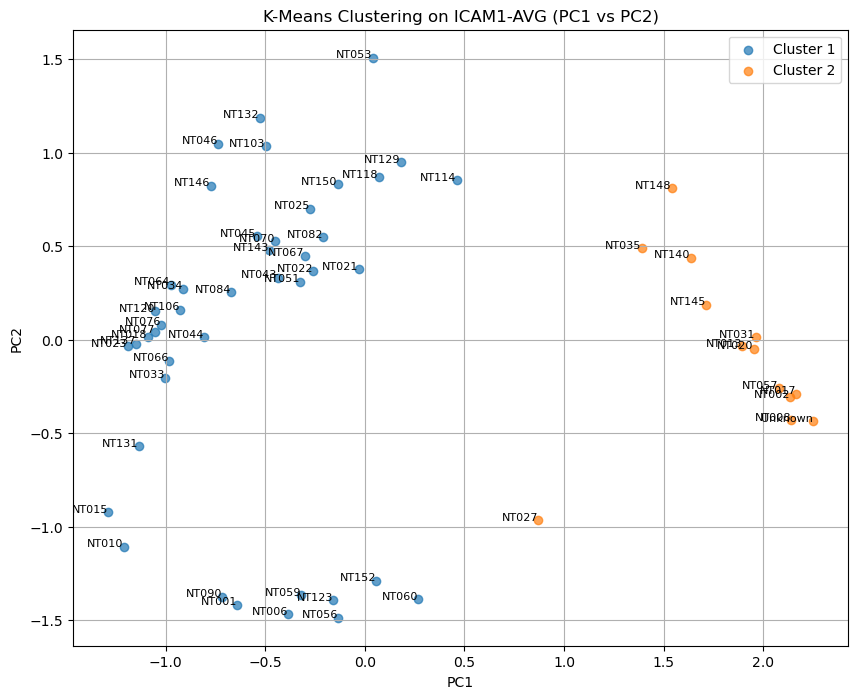

Kruskal-Wallis test result for ICAM1-AVG (K-Means): H-statistic = 0.5610389610389745, p-value = 0.4538419320508901

Assignments and ICAM1-AVG Values:
   NutriTech ID  Cluster   ICAM1-AVG
3         NT044        0  255.313924
2         NT043        0  226.831434
6         NT056        0  221.055772
5         NT051        0  215.183143
10        NT067        0  118.807174
12        NT150        0  253.487275
8         NT060        0  184.697288
28        NT137        0  244.031624
24        NT033        0  199.514632
23        NT066        0  207.157354
22        NT021        0  197.389255
21        NT103        0  412.033565
19        NT010        0  167.191012
18        NT045        0  277.344476
17        NT132        0  369.170995
16        NT120        0  268.242132
30        NT023        0  187.847345
25        NT034        0  223.528748
26        NT143        0  256.151366
27        NT015        0  260.817345
31        NT076        0  163.299570
29        NT106        0  334.707407

In [26]:
# Example usage
analyze_pca_kmeans_vs_median(
    file_ID='W5D3T240_',
    n_components_pca=4,
    clusters_to_use=2,
    pc_x=0, #+1 , 0 based
    pc_y=1, #+1, 0 based
    variable_to_compare='ICAM1-AVG',
    method='kmeans'  # Can be 'kmeans', 'median_split', or both
)